<a href="https://colab.research.google.com/github/GerardvandenEynden/FintechAI-Solutions-Smart-CTRL-f/blob/main/presentatie_smart_ctrl_f_(25_12_2025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FintechAI Solutions Smart CTRL-f
model for automated text retrieval from PDF files


Colab-notebook: /content/drive/MyDrive/Colab Notebooks/Rabobank smart ctrl-f/Presentatie smart ctrl-f (25-12-2025).ipynb

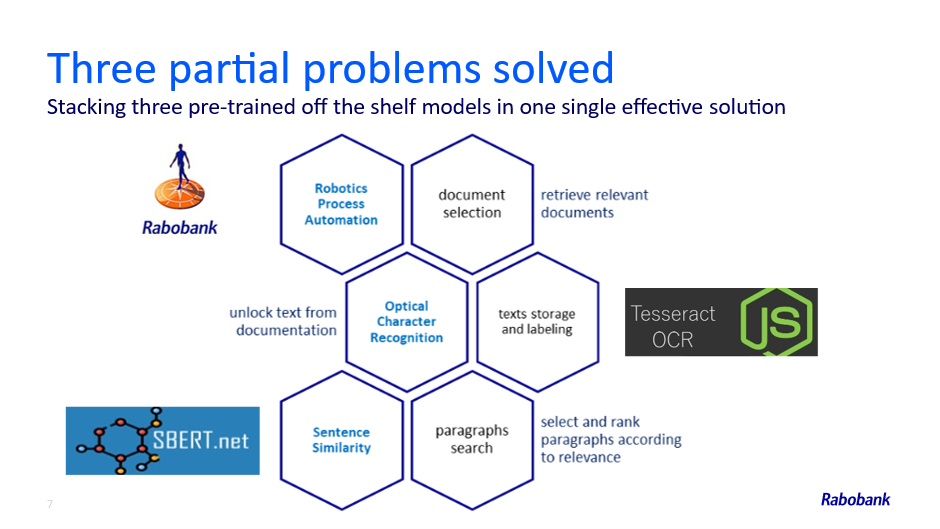

The account teams of Wholesale & Rural need insight in the Financial Undertakings and Conditions Subsequent agreements with their clients om a daily basis, apart from other clauses in the LMA SFA documentation, in order to monitor their clients in a complete and timely manner. Unfortunately these clauses are in unstructured PDF-files and require manual transcriptions to retrieve the desired information on their definitions, dates and names. At the moment the mid office copies these clauses, checks them with the account manager after which credit control uploads them in the CRM system for future use by the analyst. Furthermore, the PDF-files have many different formats and the documentation is, in spite of the LMA standardization rulings, not uniform.

# 1. install libraries & import packages

PymuPDF (muPDF for Python https://pypi.org/project/PyMuPDF/) is a lightweight toolkit for handeling PDF files which can do optical character recognition with Tesseract. Originally it was developed by Artifex as an e-viewer. The module --fitz-- handles all kinds of PDF's very easy and takes care of saving and retrieving the files and documents. We only use the functions for text extraction here. Sentence-transformers installs the packages from Huggingface (https://huggingface.co/)  where also many BERT transformer models are available. We focus on the functions for transforming text into vectors (embeddings) and calculating the cosine-similarity btween them with scikit-learn. This is the section NLP with Sentence Similarity (1.289 models).

The libraries of PymuPDF and Sentence-transformers contain many other NLP packages we import severeal packages next to this. Also we mount the Google Colab Drive where we retrieve the PDF-files (input) from and store the DataFrames (output). Pathlib, os, glob, gc and pickle are used to handle files and docs via Colab. Pandas, numpy are used for the DataFrames, fitz, sentence_transformers and util for the OCR and similarity funtions.

In [ ]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 72.2 MB/s eta 0:00:00


In [ ]:
pip install -U sentence-transformers

In [ ]:
# packages for OCR, NLP and similarity functions
import pandas as pd
import numpy as np
import re
import fitz
from sentence_transformers import SentenceTransformer, util

# packages for the handling of files and dataframes via Colab
from pathlib import Path
import os
import glob
from google.colab import files
import gc
import pickle
#from google.colab import drive
#drive.mount('/content/drive')

# 2. create 4 definitions for pipeline-code

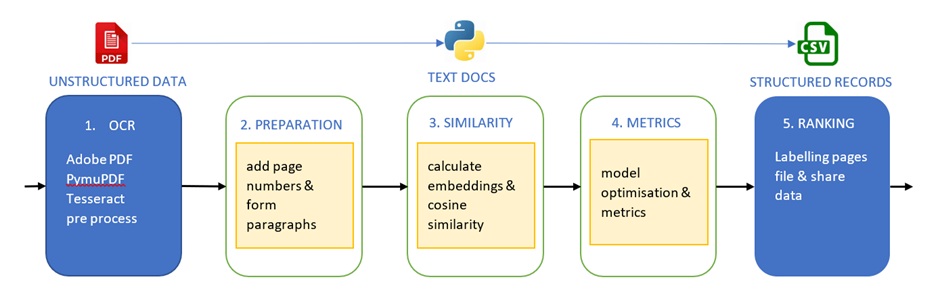

## convert PDF-files into a DataFrame using OCR (Teseract) and Pandas.

PymuPDF works with 'pages' created from the PDF-doc which fitz opens, and turns these into pixmaps. In this way the pages are graphically scanned one at the time (.get_pixmap method) and are stored as uniform pictures of the original pages in .JPG format. Next, these pages are optically recognized with Tesseract (.get_text method). Here muPDF offers the option of creating texts (sentences)  or blocks; the second retrieves blocks of sentences of about 4-6. Because an objectve definition of a paragraph does not exist this is a welcome approximation which we will use. Other solutions are available in other modules but more complicated to code. Because of its grapical origin, the blocks of texts come from the PDF document with spatial coordinates, which we shall not be using further.

- creating numpy vectors or listcomprehensions would make the code run faster.

In [ ]:
# this definition puts the text of PDF-doc's into a DataFrame
def PDF_to_DF(doc):
    doc_file = []
    for page in doc:
          # scan per page into .JPG, then OCR with .get_text() function and store texts in the doc_file list
          pix = page.get_pixmap()
          blocks = page.get_text('blocks')
          doc_file.append(blocks)

          # create DataFrame with columns corresponding to the doc_file text-elements and append these
          df = pd.DataFrame(columns = ['A', 'B', 'C', 'D', 'text', 'block', 'page'])
          for i in doc_file:
              df_temp = pd.DataFrame(i, columns = ['A', 'B', 'C', 'D', 'text', 'block', 'page'])
              df = df.append(df_temp)

    return df


## add pagenumbers, group by paragraphs and drop columns.

Firstly we add a columns with page numbers; the model only counts the blocks consecutively and page numbers are not given. This is a simple counter.
We turn the texts-cells into paragraph-cells by combining the number of blocks of texts according to the number of blocks per paragraph which we chose at the start (variable x, derived from paragraphs which is the integer of the blocks_nr entered). This is allso a simple counter (cycle) in a new column which can be grouped together. Other ways to construct paragraphs are possible like rolling or variable ones.
We group the blocks together into paragraphs (.groupby method) and create a new column for this. For the model to work properly we then clean the DataFrame from the columns with the spatial locators (A to D) and the duplicate rows of paragraphs.


In [ ]:
# this definition adds a columns for the page nubers and paragraph counter and drops the unnecessary ones
# the input is the DataFrame and the number of blocks grouped into a paragraph (paragraphs = blocks_nr)
def add_pages_paragraphs(df, paragraphs):
    page_nr = []
    a = 0
    # this part uses the counter given for the blocks which starts over with zero on every new page
    for i in range(len(df)):
      if df.iloc[i, 5] < df.iloc[i-1, 5]:
        a = a + 1
        page_nr.append(a)
      else:
        a = a
        page_nr.append(a)
    df['page_nr'] = page_nr

    new_id = []
    x = paragraphs
    y = round(len(df) / x)
    # this part adds the paragraph number to the rows, the length of it is given as inputvariable x
    for i in range(y):
      for j in range(x):
        new_id.append(i + 1)
    z = len(new_id) - len(df)
    if z < 0:
      new_id.extend(range(0, -z))
    elif z == 0:
      new_id = new_id
    else:
      new_id = new_id[:-z]
    df['new_id'] = new_id

    # the blocks are grouped by paragraph number and the unnecessary ones are dropped
    df['paragraph'] = df.groupby(['new_id'])['text'].transform(lambda x : ' '.join(x))
    df = df.drop(['A'], axis=1)
    df = df.drop(['B'], axis=1)
    df = df.drop(['C'], axis=1)
    df = df.drop(['D'], axis=1)
    df = df.drop_duplicates(subset=['paragraph'])
    df.reset_index(inplace = True)
    df = df.drop(['index'], axis=1)

    return df


## calculate embeddings and similarity scores using sentence_transformers.

The embeddings are calculated with the SBERT transformers (.encode method) and this is done with the model of the vectorspace which is chosen at te start. The model has a great influence on the processing time, on out PDF files with the 'all-MiniLM-L6-v2' model and paragraphs made of 20 blocks it takes about seven minutes. The cosine similarity scores of the scikit-learn module are calculated using the util package (.util.cos_sim method). This metric compares the embedding of the template paragraph, which is calculated immediately after installing the model, with the paragraphs in the DataFrame.

In [ ]:
# the paragraphs are encoded into embeddings and cosine similarity scores with the template are calculated
def add_embeddings_cosinescores(df):
    embeddings = []
    scores = []
    for i in range(len(df)):
      paragraph = df.iloc[i,5]
      emb = model.encode(paragraph)
      cos_sim = util.cos_sim(template, emb)
      embeddings.append(emb)
      # the tensor object is reshaped by numpy as a float column and appended to the DataFrame so it kan be ranked later on
      scores.append(cos_sim.numpy().reshape(-1)[0])
    df['score'] = scores
    df.reset_index(inplace = True)
    df = df.drop(['index'], axis=1)

    return df


## clean, sort and save the DataFrame.

We can use the cosine score column to sort the DataFrame with the highest similarity score on top. We then (arbitrarily) take the top twenty rows, and sort this much shorter DataFrame according to the page numbers. The result is a list of paragraphs that starts with the page where the top paragraphs has the highest similarity score. This shortlist can be shared with the user in their application Riccs and is saved. The name of this saved DataFrame consists of the path in Google Colab Drive, the PDF filename, the model number and number of blocks per paragraph. We also save the original DataFrame in this manner and will use this to make a scatterplot of the paragraphs per page and score. We use pickle to handle the DataFrames.

In [ ]:
def clean_and_save_df(df, x):
    # the column page is dropped here arbitrarily
    df = df.drop(['page'], axis=1)
    df_sorted = df.sort_values(by=['score'], ascending=False)
    pd.options.display.max_colwidth = 40000
    df_ranked_by_page = df_sorted.head(20).sort_values(by=['page_nr'], ascending=True)

    # the output for every batch is saved in its corresponding folder
    path_df = '/content/drive/MyDrive/Colab Notebooks/LMA documentation/dataframes#3/'

    # the ranked DataFrame is used to produce the pararaphs, these are not in the form of printed texts
    # the unsorted DataFrame is used for the graphical depiction of the scores per paragraph later on
    df_ranked_by_page.to_pickle(f"{path_df}{file_name}_model{m}_{x}.pkl")
    df.to_pickle(f"{path_df}{file_name}_model{m}_{x}_graph.pkl")


# 3. select model & model parameters

On the webpage of Huggingface (Sentence Similarity) there are 75 models for the english language of which 69 for the 'sentence_transformers' library. We chose from the most downloaded the simple models all-mini and all-mpnet because they are quick. The sentence-t5 models do not improve the results. Other models take more than two hours per PDF file or are to big to download for the GPU.

1. 'all-MiniLM-L6-v2'
2. 'all-mpnet-base-v2'
3. 'all-MiniLM-L12-v2'
4. 'sentence-t5-base'
5. 'sentence-t5-large'







In [ ]:
m = input("Enter number of model: ")

Enter number of model: 1


In [ ]:
models = ['all-MiniLM-L6-v2', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2', 'sentence-t5-base', 'sentence-t5-large']
model = SentenceTransformer(models[int(m)])
template = model.encode('25.1 Financial statements The Parent shall supply to the Agent in sufficient copies for all the Lenders: (a) as soon as they are available, but in any event within [ ] days after the end of each of its Financial Years: (i) its audited consolidated financial statements for that Financial Year; (ii) the audited financial statements (consolidated if appropriate) of each Obligor for that Financial Year; [and (iii) the audited financial statements of any other [Material Company]/[Restricted Subsidiary] for that Financial Year if requested by the Agent]; (b) [as soon as they are available, but in any event within [ ] days after the end of each Financial Quarter of each of its Financial Years its consolidated financial statements for that Financial Quarter;] and (c) as soon as they are available, but in any event within [ ] days after the end of each month its financial statements on a consolidated basis for that month (to include cumulative management accounts for the Financial Year to date)')
print('model chosen: ', models[int(m)]), model

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model chosen:  all-mpnet-base-v2


(None,
 SentenceTransformer(
   (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
   (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
   (2): Normalize()
 ))

A small number of blocks of text per paragraph (from 1-5) result in too many high scoring paragraphs: the model finds to many similarities in small texts. On the other hand too many blocks per paragraph (more than 40) result in a single high scoring paragraph but this paragraph contains to much irrelevant text. We found an optimum between 15 and 20 blocks per paragraph (around 100 sentences).

In [ ]:
blocks_nr = input("Enter number of blocks per paragraph: ")

Enter number of blocks per paragraph: 20


In [ ]:
path_pdf = '/content/drive/MyDrive/Colab Notebooks/LMA documentation/documentatie#3'
file_paths = glob.glob(os.path.join(path_pdf,'*.PDF')) + glob.glob(os.path.join(path_pdf,'*.pdf'))
len(file_paths), file_paths

(0, [])

# 4. execute code on files

PDF files (LMA SFA documents) are saved in batches in the folder 'documentatie#23' on the Google Colab Drive, specified by the variable 'path_pdf'. The paths per PDF file are listed using glob in the previous block of code. The for loop cycles through this list and retrieves the file using fitz (fitz.open method). We save the filename for when the DataFrames are saved and print a message 'busy' is given. The loop then runs the four definitions one after the other. One PDF file takes about 10 minutes per cycle with model 1 and paragraphs of 20 blocks. Other models and smaller paragraphs increase the processing time a lot. The 15 PDF files in documentation#3 takes about 1:50 hours to complete in total.

In [ ]:
for i in range(len(file_paths)):
    file_path = file_paths[i]
    doc = fitz.open(file_path)
    file_name = os.path.basename(file_path)
    print('busy working on:', file_name)
    df = PDF_to_DF(doc)
    df = add_pages_paragraphs(df, int(blocks_nr))
    df = add_embeddings_cosinescores(df)
    clean_and_save_df(df, int(blocks_nr))
    print('completed')


# 5. print scatterplot with metrics

effect of chunk-size: Scatterplots of the same document divided up in 40 (left) and 2 (right) blocks per paragraph. Red are significant similar paragraphs. in this case bigger paragraphs give a more clear result.

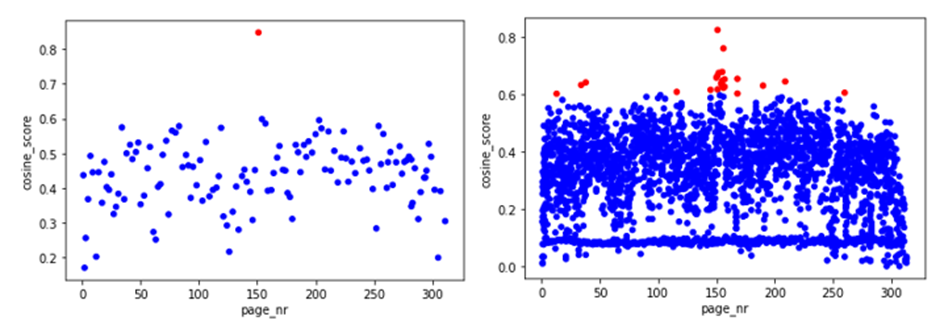

In [ ]:
pickle_path = '/content/drive/MyDrive/Colab Notebooks/LMA documentation/dataframes#3'
pickle_paths = glob.glob(os.path.join(pickle_path,'*graph.pkl'))
len(pickle_paths), pickle_paths

(0, [])

Because of a lack of a proper metric we evaluate the model visually by printing scatterplots. We strive to minimise the False Negatives. The plot shows all the paragraphs in the document ordered per page (x) and cosine-similarity score (y). When working correctly, the paragaph with the highest score is on the page where the chapter 'Financial Undertakings' starts. The model thus finds the correct chapter which is searched for. The coloring in red can be adjusted by changing the cut-off rate of the scores.

With the last document, the relevant chapter was found in the appendix (schedule 14) on page 221 and has a slightly different wording. Because of this the model finds this paragraph similar but also gives a high score to the financial undertakings chapter on page 108, possibly because of the context in the surrounding texts. As stipulated, finding two spikes is no problem as long as there is no relevant paragraph missed.

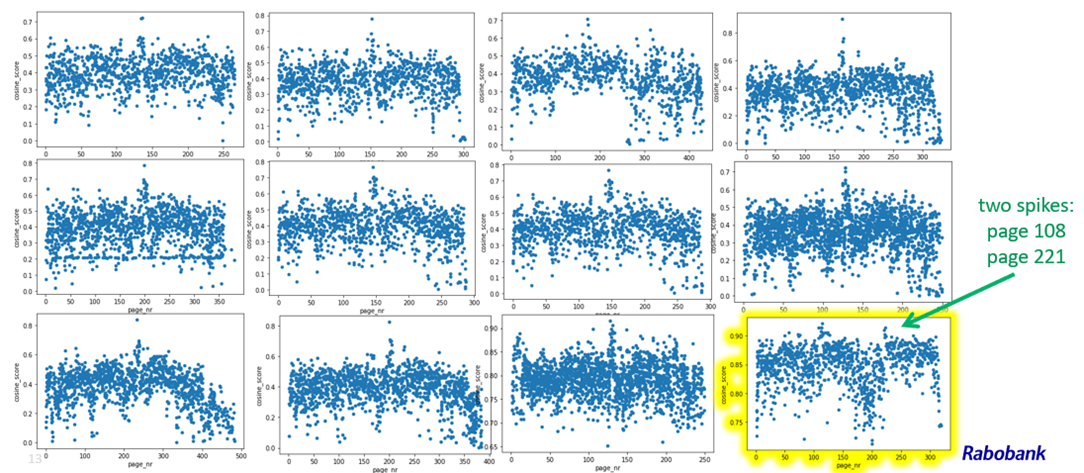

In [ ]:
for i in range(len(pickle_paths)):
    path_pickle = pickle_paths[i]
    df_scatterplot = pd.read_pickle(path_pickle)
    df_scatterplot.plot.scatter(x = 'page_nr', y = 'score', title=path_pickle)